##  Custom regression models

Like for univariate models, it is possible to create your own custom parametric survival models. Why might you want to do this? 

 - Create new / extend AFT models using known probability distributions
 - Create a piecewise model using domain knowledge about subjects
 - Iterate and fit a more accurate parametric model

*lifelines* has a very simple API to create custom parametric regression models. You only need to define the cumulative hazard function. For example, the cumulative hazard for the constant-hazard regression model looks like:

$$ 
H(t, x) = \frac{t}{\lambda(x)}\\ \lambda(x) = \exp{(\vec{\beta} \cdot \vec{x}^{\,T})}
$$ 

where $\beta$ are the unknowns we will optimize over. 


Below are some example custom models.

In [1]:
from lifelines.fitters import ParametricRegressionFitter
from autograd import numpy as np
from lifelines.datasets import load_rossi


class ExponentialAFTFitter(ParametricRegressionFitter):
    
    # this class property is necessary, and should always be a non-empty list of strings. 
    _fitted_parameter_names = ['lambda_']
    
    def _cumulative_hazard(self, params, t, Xs):
        # params is a dictionary that maps unknown parameters to a numpy vector. 
        # Xs is a dictionary that maps unknown parameters to a numpy 2d array 
        beta = params['lambda_']
        X = Xs['lambda_']
        lambda_ = np.exp(np.dot(X, beta))
        return t / lambda_
    

rossi = load_rossi()
rossi['intercept'] = 1.0

# the below variables maps dataframe columns to parameters
regressors = {
    'lambda_': rossi.columns
}

eaf = ExponentialAFTFitter().fit(rossi, 'week', 'arrest', regressors=regressors)
eaf.print_summary()

ICI =  0.027226192838563718
E50 =  0.02894862605432391


(<matplotlib.axes._subplots.AxesSubplot at 0x122a7cbd0>,
 0.027226192838563718,
 0.02894862605432391)

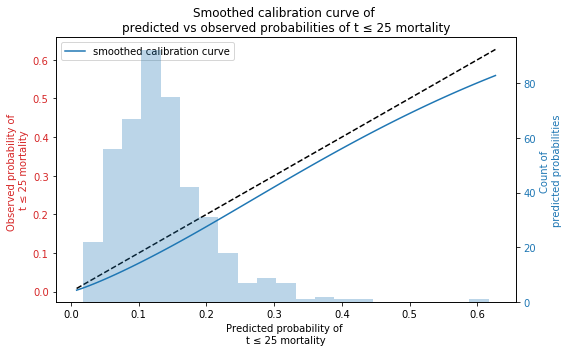

In [9]:
from lifelines.calibration import survival_probability_calibration

fig, ax = plt.subplots(figsize=(8, 5))

survival_probability_calibration(eaf, rossi, 25, ax=ax)

### Cure models

Suppose in our population we have a subpopulation that will never experience the event of interest. Or, for some subjects the event will occur so far in the future that it's essentially at time infinity. In this case, the survival function for an individual should not asymptically approach zero, but _some positive value_. Models that describe this are sometimes called cure models (i.e. the subject is "cured" of death and hence no longer susceptible) or time-lagged conversion models. 

It would be nice to be able to use common survival models _and_ have some "cure" component. Let's suppose that for individuals that will experience the event of interest, their survival distrubtion is a Weibull, denoted $S_W(t)$. For a random selected individual in the population, thier survival curve, $S(t)$, is:

$$ 
\begin{align*}
S(t) = P(T > t) &= P(\text{cured}) P(T > t\;|\;\text{cured}) +  P(\text{not cured}) P(T > t\;|\;\text{not cured})  \\
      &= p + (1-p) S_W(t)
\end{align*}
$$

Even though it's in an unconvential form, we can still determine the cumulative hazard (which is the negative logarithm of the survival function):

$$ H(t) =  -\log{\left(p + (1-p) S_W(t)\right)} $$

In [2]:
from autograd.scipy.special import expit

class CureModel(ParametricRegressionFitter):
    _scipy_fit_method = "SLSQP"
    _scipy_fit_options = {"ftol": 1e-10, "maxiter": 200}

    _fitted_parameter_names = ["lambda_", "beta_", "rho_"]

    def _cumulative_hazard(self, params, T, Xs):
        c = expit(np.dot(Xs["beta_"], params["beta_"]))

        lambda_ = np.exp(np.dot(Xs["lambda_"], params["lambda_"]))
        rho_ = np.exp(np.dot(Xs["rho_"], params["rho_"]))
        sf = np.exp(-(T / lambda_) ** rho_)

        return -np.log((1 - c) + c * sf)


cm = CureModel(penalizer=0.0)

rossi = load_rossi()
rossi["intercept"] = 1.0

covariates = {"lambda_": rossi.columns, "rho_": ["intercept"], "beta_": ['intercept', 'fin']}

cm.fit(rossi, "week", event_col="arrest", regressors=covariates, timeline=np.arange(250)) 
cm.print_summary(2)

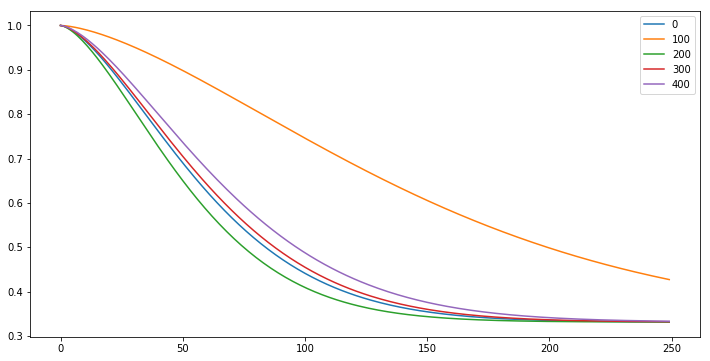

In [3]:
cm.predict_survival_function(rossi.loc[::100]).plot(figsize=(12,6))

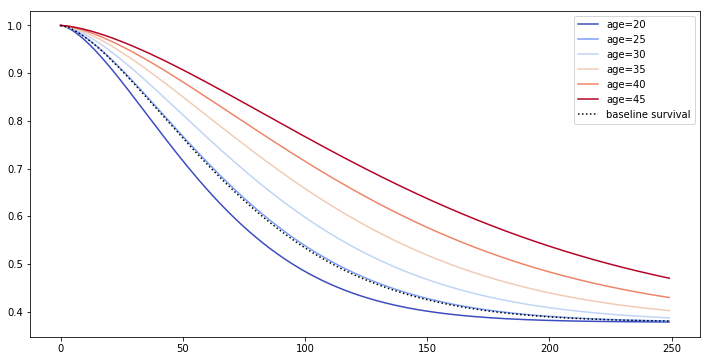

In [4]:
# what's the effect on the survival curve if I vary "age"
fig, ax = plt.subplots(figsize=(12, 6))

cm.plot_covariate_groups(['age'], values=np.arange(20, 50, 5), cmap='coolwarm', ax=ax)

ICI =  0.0025660960118482753
E50 =  0.0018552649672565757


(<matplotlib.axes._subplots.AxesSubplot at 0x12286d910>,
 0.0025660960118482753,
 0.0018552649672565757)

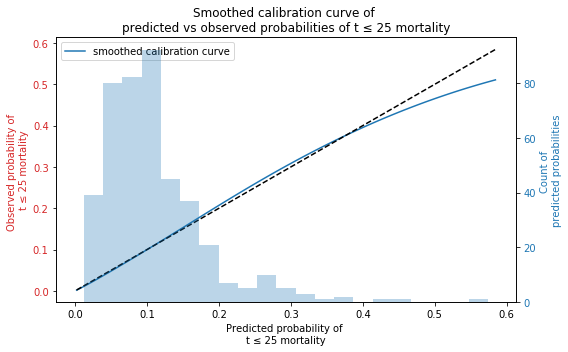

In [8]:
from lifelines.calibration import survival_probability_calibration

fig, ax = plt.subplots(figsize=(8, 5))

survival_probability_calibration(cm, rossi, 25, ax=ax)

### Spline models

See `royston_parmar_splines.py` and `crowther_royston_clements_splines.py` in the examples folder: https://github.com/CamDavidsonPilon/lifelines/tree/master/examples

Note in the below model the use of `_create_initial_point`, and one of the parameters is non-zero initially. This is important as it nudges the model slightly away from the degenerate all-zeros model. Try setting it to 0, and watch the model fail to converge. 

In [42]:
class SplineFitter:
    # this is also available in lifelines.fitters.mixins - it's reproduced here for example's sake.
    
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    def basis(self, x, knot, min_knot, max_knot):
        lambda_ = (max_knot - knot) / (max_knot - min_knot)
        return self.relu(x - knot) ** 3 - (
            lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3
        )

class PHSplineFitter(SplineFitter, ParametricRegressionFitter):
    """
    Proportional Hazard model with baseline modelled as a spline

    References
    ------------
    Royston, P., & Parmar, M. K. B. (2002). Flexible parametric proportional-hazards and proportional-odds models for censored survival data, with application to prognostic modelling and estimation of treatment effects. Statistics in Medicine, 21(15), 2175–2197. doi:10.1002/sim.1203 
    """

    _fitted_parameter_names = ["beta_", "phi0_", "phi1_", "phi2_"]

    def _create_initial_point(self, Ts, E, entries, weights, Xs):
        return {
             "beta_": np.zeros(len(Xs.mappings["beta_"])), 
             "phi0_": np.array([0.0]), 
             "phi1_": np.array([0.1]),
             "phi2_": np.array([0.0])
            }
        
    
    def set_knots(self, T, E):
        self.knots = np.percentile(np.log(T[E.astype(bool).values]), np.linspace(5, 95, 3))

    def _pre_fit_model(self, Ts, E, df):
        # this function runs before the model is fit and can be used to set data-determined values (like knots)
        self.set_knots(Ts[0], E)
        
    def _cumulative_hazard(self, params, T, Xs):
        lT = np.log(T)
        return np.exp(
            np.dot(Xs["beta_"], params["beta_"]) 
            + params["phi0_"]
            + (params["phi1_"]) * lT
            + params["phi2_"] * self.basis(lT, self.knots[1], self.knots[0], self.knots[-1])
        )
    
    
rossi = load_rossi()
rossi["intercept"] = 1.0

covariates = {"beta_": rossi.columns.difference(['intercept', 'arrest', 'week']), 
              "phi0_": ["intercept"], 
              "phi1_": ["intercept"], 
              "phi2_": ["intercept"], 
             }

phf = PHSplineFitter(penalizer=0.0)
phf.fit(rossi, "week", "arrest", regressors=covariates) 
phf.print_summary(2)

ICI =  0.005080507423341433
E50 =  0.00440577738638781


(<matplotlib.axes._subplots.AxesSubplot at 0x12449ded0>,
 0.005080507423341433,
 0.00440577738638781)

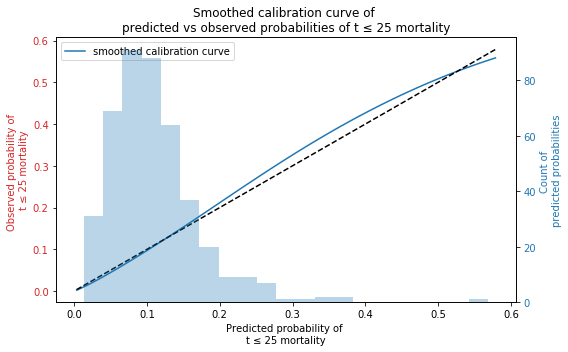

In [43]:
from lifelines.calibration import survival_probability_calibration

fig, ax = plt.subplots(figsize=(8, 5))

survival_probability_calibration(phf, rossi, 25, ax=ax)